In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np
import cv2
from PIL import Image

import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision as tv
import torch.nn.functional as F
from torch import Tensor

In [2]:
current_path = os.getcwd()
converted_path = current_path.replace('/', '\\')
print(converted_path)

\home\duong\git\DecodeItAll\bio_seman_seg\nestedunet\drive


In [3]:
bio_seg_dir = "/".join(converted_path.split("\\")[:-2])
print(bio_seg_dir)
print(os.path.exists(bio_seg_dir))

/home/duong/git/DecodeItAll/bio_seman_seg
True


In [4]:
data_dir = bio_seg_dir + "/dataset/drive"
print(os.listdir(data_dir))

['test', 'training']


In [5]:
train_dir = data_dir + "/training"
test_dir = data_dir + "/test"

train_img_dir = train_dir + "/images"
train_mask_dir = train_dir + "/1st_manual"

test_img_dir = test_dir + "/images"

print(f"No. Train Img: {len(os.listdir(train_img_dir))}")
print(f"No. Train Msk: {len(os.listdir(train_mask_dir))}")
print(f"No. Test Img: {len(os.listdir(test_img_dir))}")

No. Train Img: 20
No. Train Msk: 20
No. Test Img: 20


In [6]:
class DriveDS(Dataset):
    def __init__(self, transform = None, target_transform = None):
        from glob import glob
        self.imgs = sorted(glob(train_img_dir + "/*"))
        self.msks = sorted(glob(train_mask_dir + "/*"))
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_path = self.imgs[idx]
        msk_path = self.msks[idx]

        img = Image.open(img_path)
        msk = Image.open(msk_path)

        if self.transform:
            img = self.transform(img)

        if self.target_transform:
            msk = self.target_transform(msk)

        return (img, msk)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


20


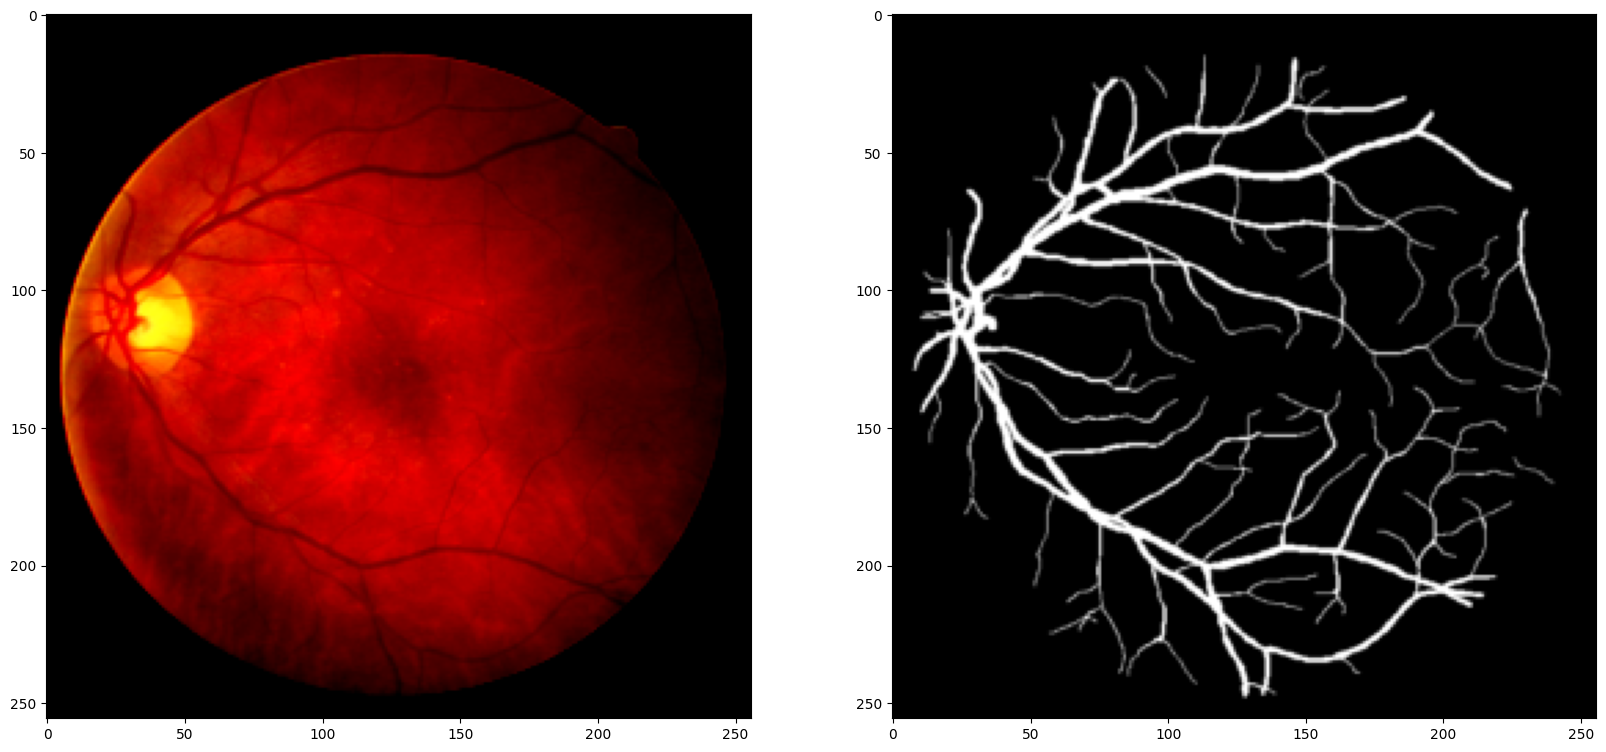

In [7]:
transform = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

target_transform = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
    ]
)

train_ds = DriveDS(transform = transform, target_transform=target_transform)

print(len(train_ds))

img, msk = train_ds[0]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 20))

ax1.imshow(img.permute(1, -1, 0).numpy())
ax2.imshow(msk.permute(1, -1, 0).numpy(), cmap = 'gray')

In [8]:
train_dl = DataLoader(train_ds, batch_size=20, shuffle=True)

print(len(train_dl))

1


In [9]:
class conv_block_nested(nn.Module):
    
    def __init__(self, in_ch, mid_ch, out_ch):
        super(conv_block_nested, self).__init__()
        self.activation = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_ch, mid_ch, kernel_size=3, padding=1, bias=True)
        self.bn1 = nn.BatchNorm2d(mid_ch)
        self.conv2 = nn.Conv2d(mid_ch, out_ch, kernel_size=3, padding=1, bias=True)
        self.bn2 = nn.BatchNorm2d(out_ch)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.activation(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        output = self.activation(x)

        return output

In [10]:
class NestedUNet(nn.Module):
    """
    Implementation of this paper:
    https://arxiv.org/pdf/1807.10165.pdf
    """
    def __init__(self, in_ch=3, out_ch=3, init_channel=16):
        super(NestedUNet, self).__init__()

        n1 = init_channel
        filters = [n1, n1 * 2, n1 * 4, n1 * 8, n1 * 16]

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv0_0 = conv_block_nested(in_ch, filters[0], filters[0])
        self.conv1_0 = conv_block_nested(filters[0], filters[1], filters[1])
        self.conv2_0 = conv_block_nested(filters[1], filters[2], filters[2])
        self.conv3_0 = conv_block_nested(filters[2], filters[3], filters[3])
        self.conv4_0 = conv_block_nested(filters[3], filters[4], filters[4])

        self.conv0_1 = conv_block_nested(filters[0] + filters[1], filters[0], filters[0])
        self.conv1_1 = conv_block_nested(filters[1] + filters[2], filters[1], filters[1])
        self.conv2_1 = conv_block_nested(filters[2] + filters[3], filters[2], filters[2])
        self.conv3_1 = conv_block_nested(filters[3] + filters[4], filters[3], filters[3])

        self.conv0_2 = conv_block_nested(filters[0]*2 + filters[1], filters[0], filters[0])
        self.conv1_2 = conv_block_nested(filters[1]*2 + filters[2], filters[1], filters[1])
        self.conv2_2 = conv_block_nested(filters[2]*2 + filters[3], filters[2], filters[2])

        self.conv0_3 = conv_block_nested(filters[0]*3 + filters[1], filters[0], filters[0])
        self.conv1_3 = conv_block_nested(filters[1]*3 + filters[2], filters[1], filters[1])

        self.conv0_4 = conv_block_nested(filters[0]*4 + filters[1], filters[0], filters[0])

        self.final = nn.Conv2d(filters[0], out_ch, kernel_size=1)


    def forward(self, x):
        
        x0_0 = self.conv0_0(x)
        x1_0 = self.conv1_0(self.pool(x0_0))
        x0_1 = self.conv0_1(torch.cat([x0_0, self.Up(x1_0)], 1))

        x2_0 = self.conv2_0(self.pool(x1_0))
        x1_1 = self.conv1_1(torch.cat([x1_0, self.Up(x2_0)], 1))
        x0_2 = self.conv0_2(torch.cat([x0_0, x0_1, self.Up(x1_1)], 1))

        x3_0 = self.conv3_0(self.pool(x2_0))
        x2_1 = self.conv2_1(torch.cat([x2_0, self.Up(x3_0)], 1))
        x1_2 = self.conv1_2(torch.cat([x1_0, x1_1, self.Up(x2_1)], 1))
        x0_3 = self.conv0_3(torch.cat([x0_0, x0_1, x0_2, self.Up(x1_2)], 1))

        x4_0 = self.conv4_0(self.pool(x3_0))
        x3_1 = self.conv3_1(torch.cat([x3_0, self.Up(x4_0)], 1))
        x2_2 = self.conv2_2(torch.cat([x2_0, x2_1, self.Up(x3_1)], 1))
        x1_3 = self.conv1_3(torch.cat([x1_0, x1_1, x1_2, self.Up(x2_2)], 1))
        x0_4 = self.conv0_4(torch.cat([x0_0, x0_1, x0_2, x0_3, self.Up(x1_3)], 1))

        output = self.final(x0_4)
        return output

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu", index = 0)

model = NestedUNet(3, 1, 16).to(device)

optimizer = Adam(params = model.parameters(), lr = 0.001)

epochs = 100

loss_fn = nn.BCEWithLogitsLoss()

In [12]:
old_loss = 1e26
best_dct = None
last_dct = None
for epoch in range(epochs):
    model.train()
    tr_total_loss = 0
    tr_total_dice = 0
    tr_total_iou = 0
    for train_img, train_mask in tqdm(train_dl):
        train_img = train_img.to(device)
        train_mask = train_mask.to(device)

        train_gen_mask = model(train_img)        
        train_loss = loss_fn(train_gen_mask, train_mask)

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()        
        
        tr_total_loss += train_loss.cpu().item()        
            
    mean_train_loss = tr_total_loss/len(train_dl)

    if mean_train_loss <= old_loss:
        old_loss = mean_train_loss
        best_dct = model.state_dict()
    
    last_dct = model.state_dict()

    print(f"Epoch: {epoch} - TrainLoss: {mean_train_loss}")
model.load_state_dict(best_dct)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.31s/it]


Epoch: 0 - TrainLoss: 0.7922755479812622


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.19it/s]


Epoch: 1 - TrainLoss: 0.7217604517936707


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.05it/s]


Epoch: 2 - TrainLoss: 0.6868661642074585


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.20it/s]


Epoch: 3 - TrainLoss: 0.656665027141571


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.00s/it]


Epoch: 4 - TrainLoss: 0.6421443223953247


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.23it/s]


Epoch: 5 - TrainLoss: 0.6256595849990845


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.22s/it]


Epoch: 6 - TrainLoss: 0.613269031047821


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.20it/s]


Epoch: 7 - TrainLoss: 0.6026325225830078


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.17s/it]


Epoch: 8 - TrainLoss: 0.5933863520622253


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.72s/it]


Epoch: 9 - TrainLoss: 0.5847370028495789


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.99s/it]


Epoch: 10 - TrainLoss: 0.5770695209503174


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.47s/it]


Epoch: 11 - TrainLoss: 0.572921872138977


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.11s/it]


Epoch: 12 - TrainLoss: 0.5692893266677856


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.78s/it]


Epoch: 13 - TrainLoss: 0.5658889412879944


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.91s/it]


Epoch: 14 - TrainLoss: 0.5614621043205261


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.85s/it]


Epoch: 15 - TrainLoss: 0.557020366191864


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.15s/it]


Epoch: 16 - TrainLoss: 0.5525928735733032


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.86s/it]


Epoch: 17 - TrainLoss: 0.5484885573387146


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.95s/it]


Epoch: 18 - TrainLoss: 0.5449321269989014


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.67s/it]


Epoch: 19 - TrainLoss: 0.5462337732315063


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.89s/it]


Epoch: 20 - TrainLoss: 0.5393136739730835


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.99s/it]


Epoch: 21 - TrainLoss: 0.5374062657356262


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.97s/it]


Epoch: 22 - TrainLoss: 0.5363242030143738


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.43s/it]


Epoch: 23 - TrainLoss: 0.5339241027832031


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.34s/it]


Epoch: 24 - TrainLoss: 0.5315576791763306


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.52s/it]


Epoch: 25 - TrainLoss: 0.5285016894340515


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.00s/it]


Epoch: 26 - TrainLoss: 0.525489330291748


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.43s/it]


Epoch: 27 - TrainLoss: 0.5224582552909851


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.32s/it]


Epoch: 28 - TrainLoss: 0.5198714137077332


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.81s/it]


Epoch: 29 - TrainLoss: 0.516280472278595


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.46s/it]


Epoch: 30 - TrainLoss: 0.5133752226829529


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.55s/it]


Epoch: 31 - TrainLoss: 0.5108651518821716


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.71s/it]


Epoch: 32 - TrainLoss: 0.5083152055740356


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/it]


Epoch: 33 - TrainLoss: 0.5058609843254089


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.05s/it]


Epoch: 34 - TrainLoss: 0.5033909678459167


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.76s/it]


Epoch: 35 - TrainLoss: 0.5010105967521667


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.48s/it]


Epoch: 36 - TrainLoss: 0.49869081377983093


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.36s/it]


Epoch: 37 - TrainLoss: 0.49666592478752136


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.50s/it]


Epoch: 38 - TrainLoss: 0.4946317672729492


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.02s/it]


Epoch: 39 - TrainLoss: 0.4925118386745453


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.79s/it]


Epoch: 40 - TrainLoss: 0.49016132950782776


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.81s/it]


Epoch: 41 - TrainLoss: 0.4880935847759247


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.02s/it]


Epoch: 42 - TrainLoss: 0.4858320653438568


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.37s/it]


Epoch: 43 - TrainLoss: 0.4838273227214813


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.65s/it]


Epoch: 44 - TrainLoss: 0.48156261444091797


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.93s/it]


Epoch: 45 - TrainLoss: 0.4795908033847809


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.51s/it]


Epoch: 46 - TrainLoss: 0.4773503243923187


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.92s/it]


Epoch: 47 - TrainLoss: 0.4752163887023926


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/it]


Epoch: 48 - TrainLoss: 0.4735170900821686


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.27s/it]


Epoch: 49 - TrainLoss: 0.4736734926700592


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.20s/it]


Epoch: 50 - TrainLoss: 0.4726695120334625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.24s/it]


Epoch: 51 - TrainLoss: 0.47024282813072205


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.60s/it]


Epoch: 52 - TrainLoss: 0.4678097665309906


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.49s/it]


Epoch: 53 - TrainLoss: 0.4649669826030731


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.39s/it]


Epoch: 54 - TrainLoss: 0.4627784788608551


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.04s/it]


Epoch: 55 - TrainLoss: 0.4604770839214325


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.72s/it]


Epoch: 56 - TrainLoss: 0.4581378996372223


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.20s/it]


Epoch: 57 - TrainLoss: 0.4555811583995819


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.65s/it]


Epoch: 58 - TrainLoss: 0.45323172211647034


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.43s/it]


Epoch: 59 - TrainLoss: 0.45079874992370605


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.86s/it]


Epoch: 60 - TrainLoss: 0.44840288162231445


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.00s/it]


Epoch: 61 - TrainLoss: 0.4460105001926422


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.37s/it]


Epoch: 62 - TrainLoss: 0.4435112476348877


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.46s/it]


Epoch: 63 - TrainLoss: 0.44109612703323364


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.76s/it]


Epoch: 64 - TrainLoss: 0.43874332308769226


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.05s/it]


Epoch: 65 - TrainLoss: 0.43628254532814026


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.92s/it]


Epoch: 66 - TrainLoss: 0.4339953362941742


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.47s/it]


Epoch: 67 - TrainLoss: 0.43172380328178406


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.04s/it]


Epoch: 68 - TrainLoss: 0.429342657327652


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.15s/it]


Epoch: 69 - TrainLoss: 0.4269688129425049


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.00s/it]


Epoch: 70 - TrainLoss: 0.42467984557151794


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.82s/it]


Epoch: 71 - TrainLoss: 0.4225655496120453


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.40s/it]


Epoch: 72 - TrainLoss: 0.4204939007759094


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.87s/it]


Epoch: 73 - TrainLoss: 0.41809526085853577


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.86s/it]


Epoch: 74 - TrainLoss: 0.41597509384155273


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.81s/it]


Epoch: 75 - TrainLoss: 0.4138476550579071


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.99s/it]


Epoch: 76 - TrainLoss: 0.41172924637794495


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.48s/it]


Epoch: 77 - TrainLoss: 0.40952426195144653


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.78s/it]


Epoch: 78 - TrainLoss: 0.4073568284511566


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.48s/it]


Epoch: 79 - TrainLoss: 0.40541505813598633


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.22s/it]


Epoch: 80 - TrainLoss: 0.4042396545410156


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.05s/it]


Epoch: 81 - TrainLoss: 0.4029904007911682


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  3.00s/it]


Epoch: 82 - TrainLoss: 0.4001327157020569


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.79s/it]


Epoch: 83 - TrainLoss: 0.39812567830085754


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.80s/it]


Epoch: 84 - TrainLoss: 0.39600488543510437


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.66s/it]


Epoch: 85 - TrainLoss: 0.39389297366142273


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.75s/it]


Epoch: 86 - TrainLoss: 0.3918538987636566


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.30s/it]


Epoch: 87 - TrainLoss: 0.38990655541419983


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.57s/it]


Epoch: 88 - TrainLoss: 0.38810959458351135


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.08s/it]


Epoch: 89 - TrainLoss: 0.3866909444332123


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.73s/it]


Epoch: 90 - TrainLoss: 0.38404011726379395


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.19s/it]


Epoch: 91 - TrainLoss: 0.3826276659965515


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.78s/it]


Epoch: 92 - TrainLoss: 0.3809843063354492


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.65s/it]


Epoch: 93 - TrainLoss: 0.3786563575267792


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.31s/it]


Epoch: 94 - TrainLoss: 0.377585232257843


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.36s/it]


Epoch: 95 - TrainLoss: 0.3754922151565552


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.20s/it]


Epoch: 96 - TrainLoss: 0.37365564703941345


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.34s/it]


Epoch: 97 - TrainLoss: 0.3716735541820526


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.27s/it]


Epoch: 98 - TrainLoss: 0.369780033826828


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.33s/it]

Epoch: 99 - TrainLoss: 0.3676566183567047


<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


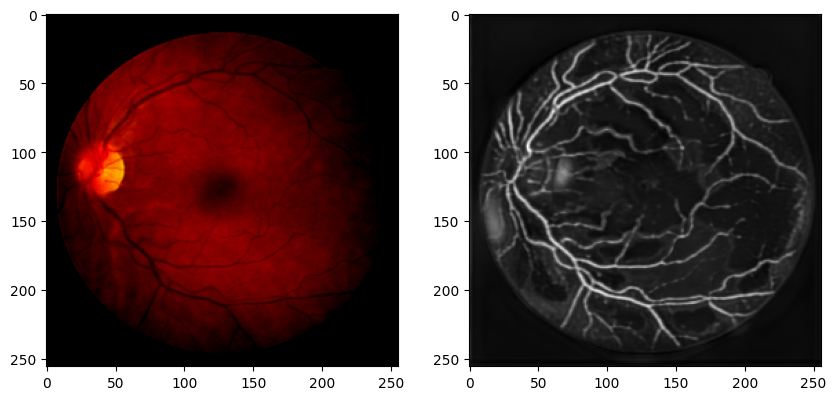

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


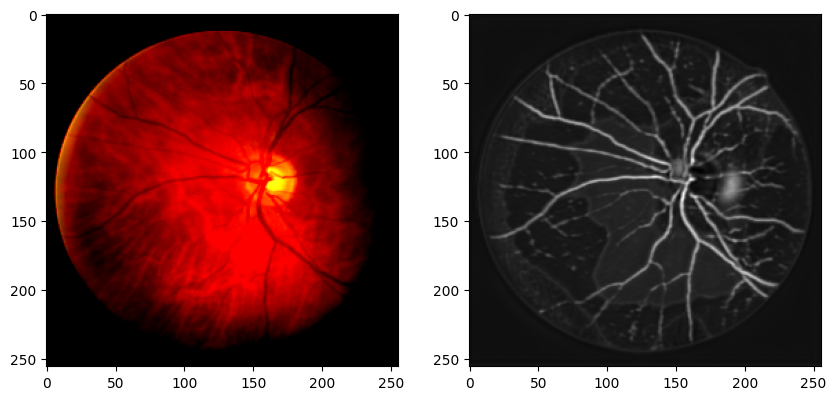

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


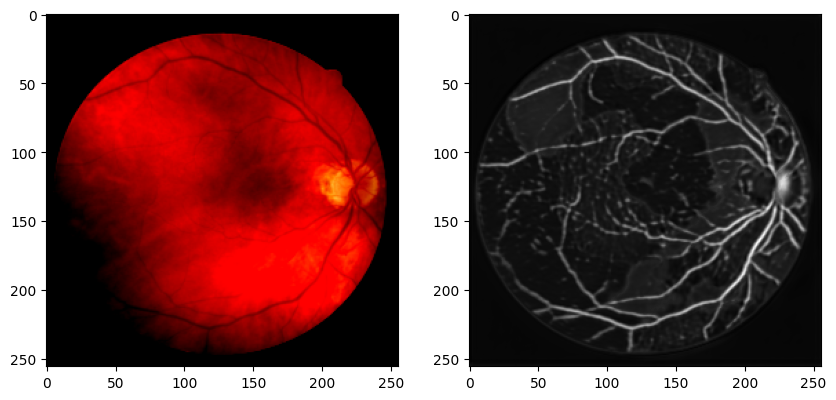

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


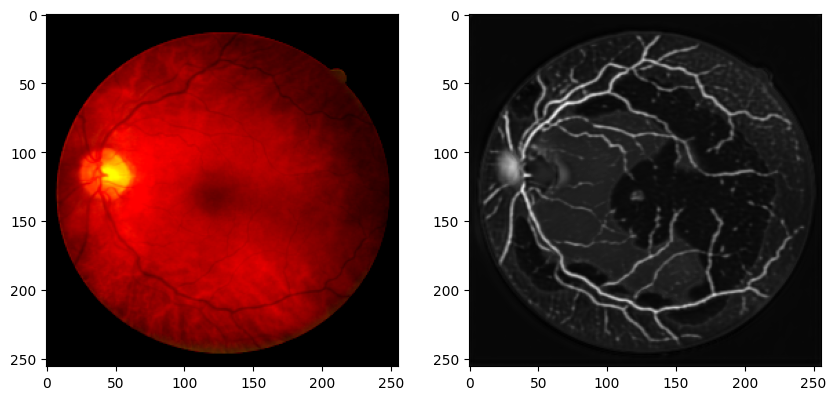

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


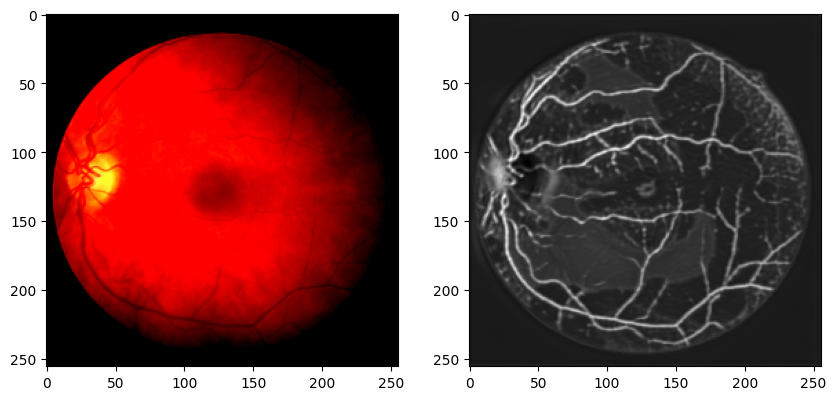

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


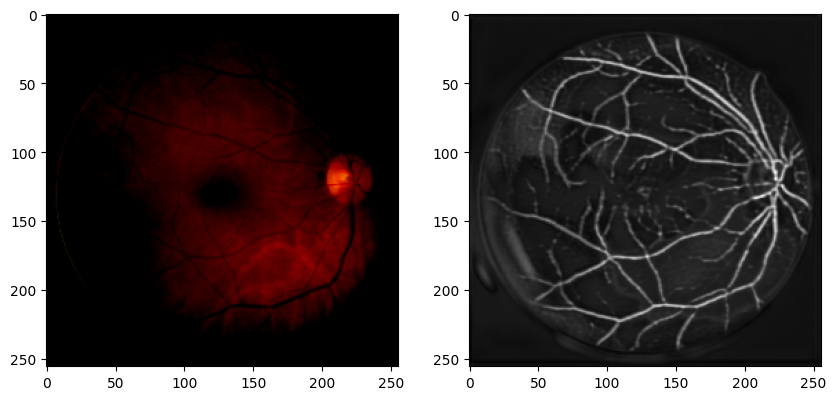

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


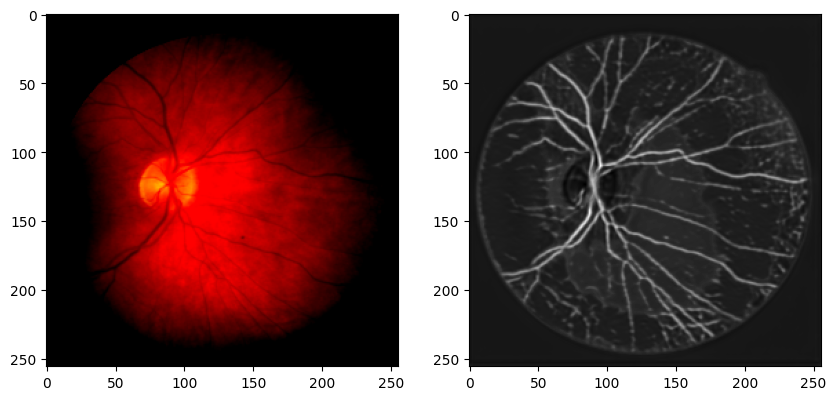

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


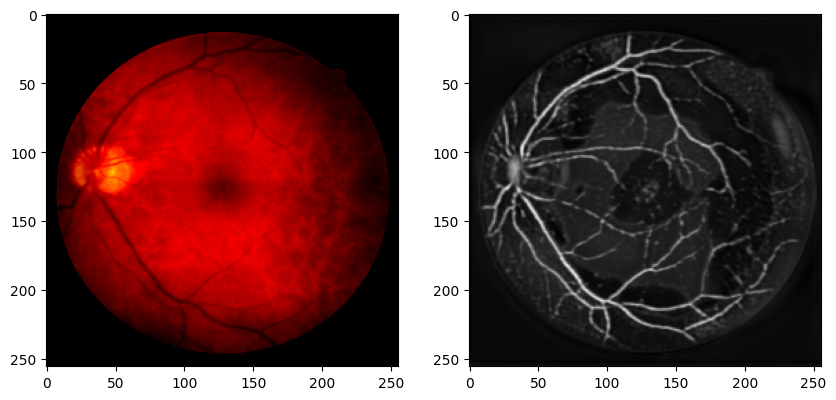

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


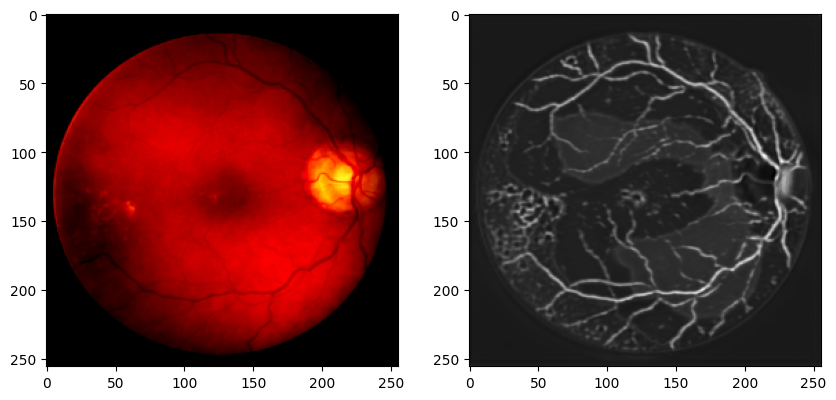

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


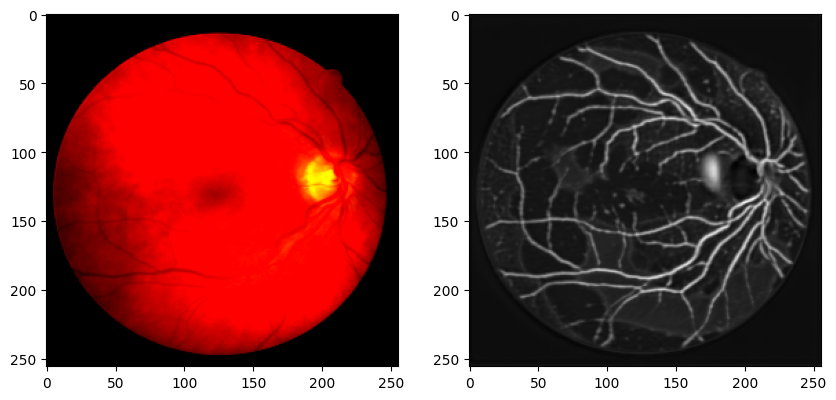

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


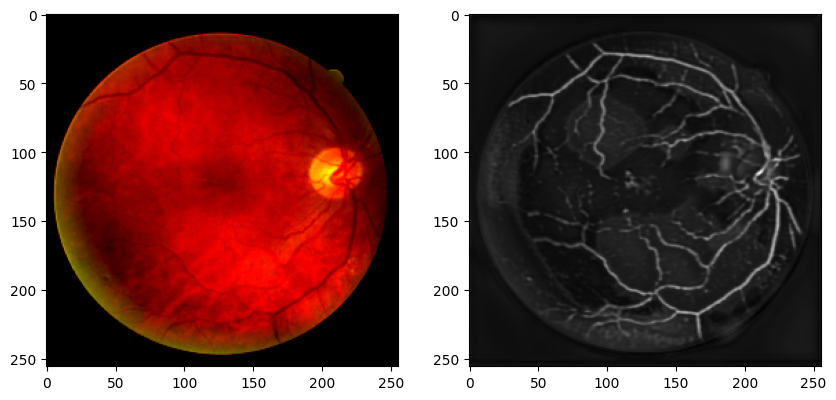

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


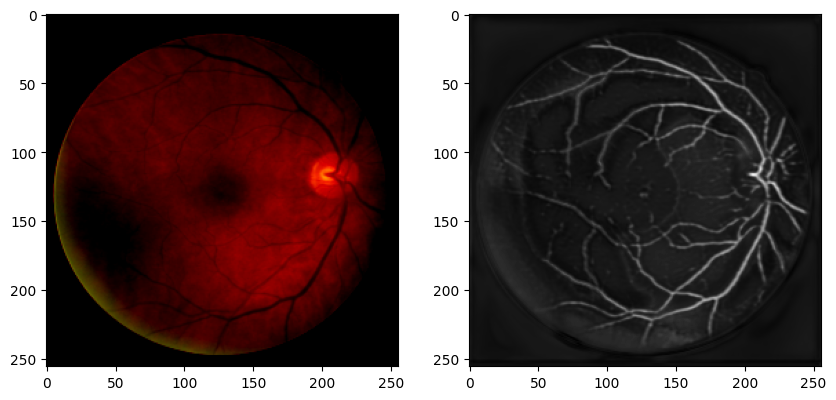

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


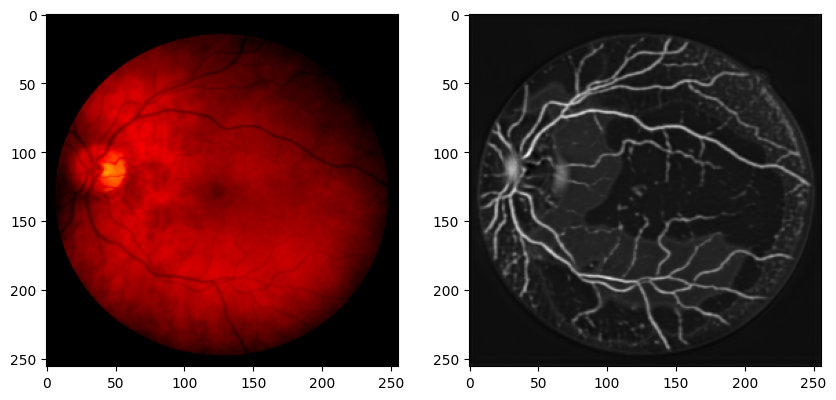

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


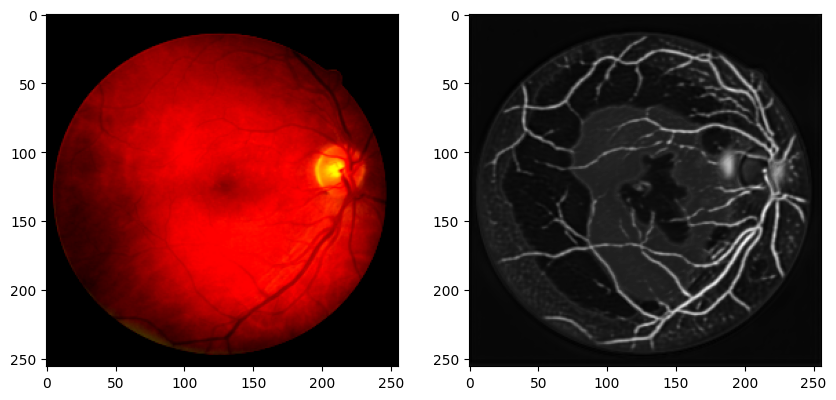

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


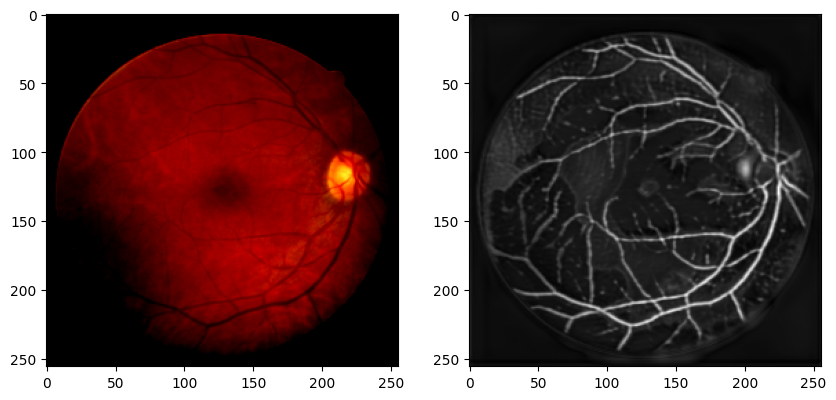

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


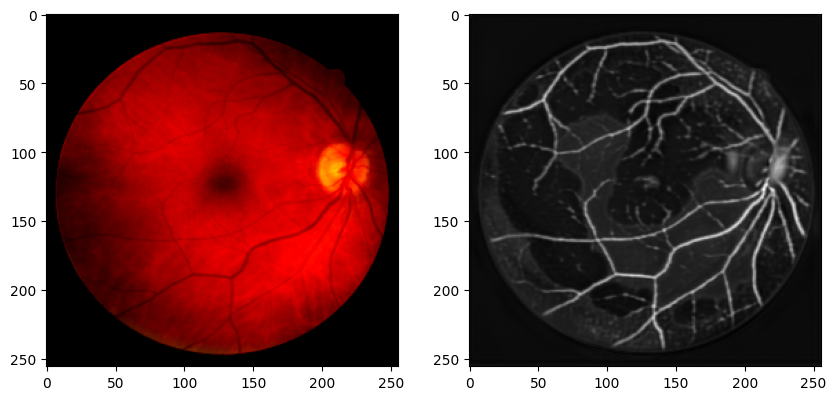

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


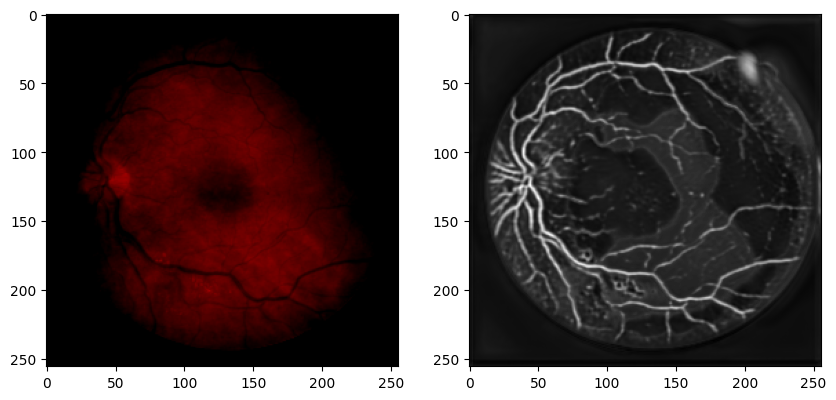

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


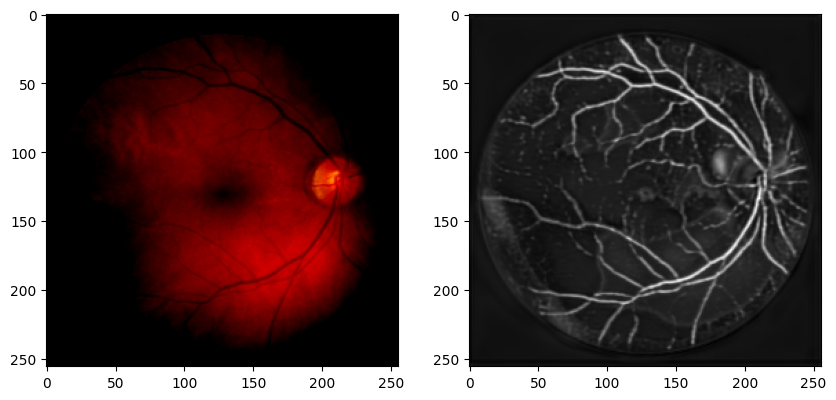

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


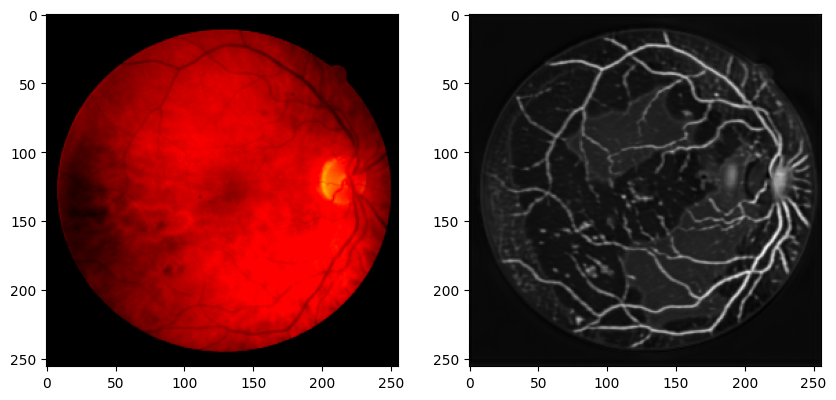

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


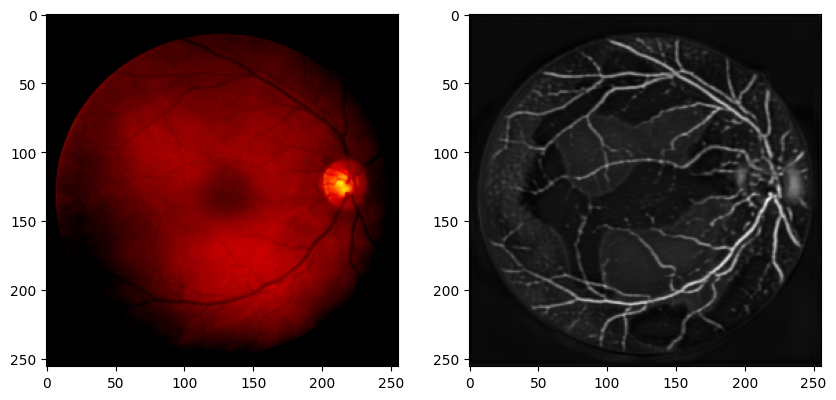

In [13]:
from glob import glob
for test_img_path in glob(test_img_dir + "/*"):
    img = transform(Image.open(test_img_path)).to(device).unsqueeze(0)

    mask = model(img)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))

    ax1.imshow(img[0].permute(1, -1, 0).detach().cpu().numpy())
    ax2.imshow(mask[0].permute(1, -1, 0).detach().cpu().numpy(), cmap = 'gray')

    plt.show()
    plt.close("all")